# DenseNet 
Todo: Discussion

In [1]:
import os
import pathlib
from glob import glob
from typing import Union

import tensorflow as tf
from bcd.model.repo import ModelRepo
from bcd.model.factory import DenseNetFactory
from bcd.model.visual import X4LearningVisualizer
from bcd.model.transfer import thaw


## Configuration

In [2]:
# Data params
batch_size = 32
input_shape = (224,224,3)
output_shape = 1
train_dir_10 = pathlib.Path("data/image/1_final/training_10/training/").with_suffix('')
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')

# Training Params
initial_epochs = 100  # Number of epochs to train for feature extraction
fine_tune_epochs = 50  # Number of epochs for each fine tune session
initial_learning_rate = 0.0001  # Base learning rate for the Adam optimizer 
loss = "binary_crossentropy"
activation = "sigmoid"

# Early stop callback 
min_delta = 0.0001
monitor = "val_loss"  # Monitor validation loss for early stopping
patience = 3  # The number of consecutive epochs for which lack of improvement is tolerated 
restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.


# ModelCheckpoint Callback parameters
location = "models/"
mode = "auto"
save_weights_only = False
save_best_only = True
save_freq = "epoch"
verbose = 1

# Model Parameters
name = "densenet"
metric = "accuracy"
model_factory = DenseNetFactory
force = False  # Whether to retrain if the model and weights already exist from a prior training session.
base_model_layer = 5 # Layer of the DenseNet base model

## Dependencies
Several dependencies will be used throughout this notebook, including:
- Early Stop Callback
- Model Repository
- DenseNet Model Factory
- Transfer Learning Visualizer

We'll make those objects available here.

In [3]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                       min_delta=min_delta,
                                                       patience=patience, 
                                                       restore_best_weights=restore_best_weights)
repo = ModelRepo(location=location)
factory = model_factory()
x4v = X4LearningVisualizer(name=name)

## Load Data

In [4]:
# Training DataSet (10%)
train_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## Feature Extraction
If the model already exists, obtain it from the repository. Otherwise, create the model and perform feature extraction.

In [5]:
stage = "feature_extraction"
if force or not repo.exists(name=name, stage=stage):
    model = factory.create(input_shape=input_shape, 
                            output_shape=output_shape, 
                            learning_rate=initial_learning_rate, 
                            trainable=False, 
                            loss=loss, 
                            activation=activation, 
                            metric=metric)
    # Obtain a checkpoint callback from the model repository 
    checkpoint_callback = repo.create_callback(name=name, stage="feature_extraction")
    # Fit the model 
    history = model.fit(train_ds_10, epochs=initial_epochs, validation_data=val_ds_10, callbacks=[checkpoint_callback, early_stop_callback])    
    # Extract initial epoch
    last_epoch = history.epoch[-1]
    # Visualize the learning curves.
    x4v(history=history)
else:
    model, last_epoch = repo.get(name=name, stage=stage)

DEBUG:ModelRepo:45-val_loss_0.64.keras
INFO:ModelRepo:Model densenet-feature_extraction epoch: 45 was found in the repository.


As expected, only the 1921 parameters in the output layer are trainable. The DenseNet model occupies the 5th layer in our overall model. This will be relevant at the fine-tuning stage as we target layers in the DenseNet model to thaw.

Let's create a checkpoint callback and fit the model with early stopping.

Excellent. We can now move on to the fine tuning stage.

## Fine Tuning 
Our objective is to adapt the DenseNet201 model, which was trained on the ImageNet dataset, to our target domain, biomedical imaging, specifically, digital mammography. An iterative-gradual fine-tuning approach is undertaken in which the model progressively adapts to the target domain by gradually unfreezing layers and training the model on the CBIS-DDSM data.

A common approach is to unfreeze the top layer, train the model until convergence, then unfreeze the next top layer, and so on. However, the DenseNet model has over 700 layers making this approach impractical. Rather than unfreezing the layers one at a time, we will adopt a gradual unfreezing of layer groups. The number of layers in each group will range from 1 to 707 on a logarithmic scale. Concretely, the unfreezing schedule will be as follows:

```{table} Gradual Fine-Tuning Schedule
| Layer Group | Group Size | Learning Rate |
|-------------|------------|---------------|
| 1           | 1          | 1.00E-05      |
| 2           | 5          | 1.00E-06      |
| 3           | 27         | 1.00E-07      |
| 4           | 137        | 1.00E-08      |
| 5           | 707        | 1.00E-09      |
```

Each fine-tuning session will trained until convergence.


In [6]:
gradual_fine_tuning_schedule = {1: {"layers": 1, "learning_rate": 1e-5},
                                2: {"layers": 5, "learning_rate": 1e-6},
                                3: {"layers": 27, "learning_rate": 1e-7},
                                4: {"layers": 137, "learning_rate": 1e-8},
                                5: {"layers": 707, "learning_rate": 1e-9},
                                }

In [7]:
def fine_tune(name: str, 
              stage: str, 
              model: tf.keras.Model, 
              train_ds: tf.data.Dataset, 
              validation_ds: tf.data.Dataset, 
              base_model_layer: int,
              layers: int, 
              learning_rate: float, 
              last_epoch: int, 
              fine_tune_epochs: int = fine_tune_epochs, 
              callbacks: Union[list, tf.keras.callbacks.Callback] = None) -> Union[tf.keras.Model, tf.keras.callbacks.History]:
    """Performs fine tuning of a model and returns the model and last epoch
    
    Args:
        name (str): Name of the model
        stage (str): Fine tuning session
        model (tf.keras.Model): The model to be trained
        train_ds (tf.data.Dataset): Training dataset
        validation_ds (tf.data.Dataset): Validation dataset
        base_model_layer (int): Layer that contains the base model
        layers (int): Top n layers to train
        learning_rate (float): Learning rate for training
        last_epoch (int): Last epoch trained in the prior session or feature extraction stage
        fine_tune_epochs (int): Number of fine tuning epochs to train, subject to early stopping.
        callbacks (Union[list, tf.keras.callbacks.Callback]): Callbacks for the fit method.

    Returns: model (tf.keras.Model) and history (tf.keras.callbacks.History)
    """

    # Remove existing 
    epochs = last_epoch + fine_tune_epochs

    # Obtain a checkpoint callback for the stage and add to callbacks
    checkpoint_callback = repo.create_callback(name=name, stage=stage)
    if callbacks is None:
        callbacks = [checkpoint_callback]
    elif isinstance(callbacks,list):
        callbacks.extend(checkpoint_callback)
    else:
        callbacks = [callbacks, checkpoint_callback]

    # Thaw the top n layers
    model = thaw(model=model, base_model_layer=base_model_layer, n=layers)

    # Recompile the model
    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=[metric])

    # Fit the model
    history = model.fit(train_ds, 
                        validation_data=validation_ds, 
                        epochs=epochs,                         
                        initial_epoch=last_epoch,
                        callbacks=callbacks)

    return model, history

### Fine Tune Session 1

In [8]:

fine_tune_layer = 1
# Order up a checkpoint callback
stage=f"fine_tuning_session_{fine_tune_layer}"
layers = gradual_fine_tuning_schedule[fine_tune_layer]["layers"]
learning_rate = gradual_fine_tuning_schedule[fine_tune_layer]["learning_rate"]

if not force and repo.exists(name=name, stage=stage):
    model, last_epoch = repo.get(name=name, stage=stage)
else:
    repo.remove(name=name, stage=stage) # Remove existing models for the stage
    
    model, history = fine_tune(name=name,
                                    stage=stage,
                                    model=model,
                                    train_ds=train_ds_10,
                                    validation_ds=val_ds_10,
                                    base_model_layer=base_model_layer,
                                    layers=layers,
                                    learning_rate=learning_rate,
                                    last_epoch=last_epoch,
                                    fine_tune_epochs=fine_tune_epochs,
                                    callbacks=early_stop_callback)
    # Check model summary
    model.summary()
    # Visualize learning curve
    x4v(history=history)
    # Extract the last epoch.
    last_epoch = history.epoch[-1]

DEBUG:ModelRepo:56-val_loss_0.64.keras
INFO:ModelRepo:Model densenet-fine_tuning_session_1 epoch: 56 was found in the repository.


### Fine Tune Session 2

In [9]:

fine_tune_layer = 2
# Order up a checkpoint callback
stage=f"fine_tuning_session_{fine_tune_layer}"
layers = gradual_fine_tuning_schedule[fine_tune_layer]["layers"]
learning_rate = gradual_fine_tuning_schedule[fine_tune_layer]["learning_rate"]

if not force and repo.exists(name=name, stage=stage):
    model, last_epoch = repo.get(name=name, stage=stage)
else:
    repo.remove(name=name, stage=stage) # Remove existing models for the stage
    
    model, history = fine_tune(name=name,
                                    stage=stage,
                                    model=model,
                                    train_ds=train_ds_10,
                                    validation_ds=val_ds_10,
                                    base_model_layer=base_model_layer,
                                    layers=layers,
                                    learning_rate=learning_rate,
                                    last_epoch=last_epoch,
                                    fine_tune_epochs=fine_tune_epochs,
                                    callbacks=early_stop_callback)
    # Check model summary
    model.summary()
    # Visualize learning curve
    x4v(history=history)
    # Extract the last epoch.
    last_epoch = history.epoch[-1]

DEBUG:ModelRepo:81-val_loss_0.64.keras
INFO:ModelRepo:Model densenet-fine_tuning_session_2 epoch: 81 was found in the repository.


### Fine Tune Session 3

INFO:ModelRepo:Deleted 0 densenet models from stage fine_tuning_session_3.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                

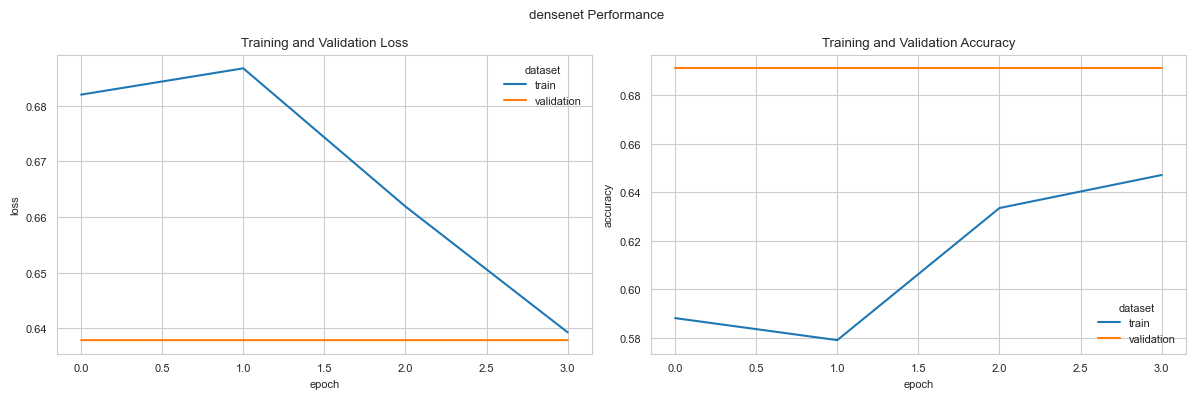

In [10]:

fine_tune_layer = 3
# Order up a checkpoint callback
stage=f"fine_tuning_session_{fine_tune_layer}"
layers = gradual_fine_tuning_schedule[fine_tune_layer]["layers"]
learning_rate = gradual_fine_tuning_schedule[fine_tune_layer]["learning_rate"]

if not force and repo.exists(name=name, stage=stage):
    model, last_epoch = repo.get(name=name, stage=stage)
else:
    repo.remove(name=name, stage=stage) # Remove existing models for the stage
    
    model, history = fine_tune(name=name,
                                    stage=stage,
                                    model=model,
                                    train_ds=train_ds_10,
                                    validation_ds=val_ds_10,
                                    base_model_layer=base_model_layer,
                                    layers=layers,
                                    learning_rate=learning_rate,
                                    last_epoch=last_epoch,
                                    fine_tune_epochs=fine_tune_epochs,
                                    callbacks=early_stop_callback)
    # Check model summary
    model.summary()
    # Visualize learning curve
    x4v(history=history)
    # Extract the last epoch.
    last_epoch = history.epoch[-1]

### Fine Tune Session 4

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                             

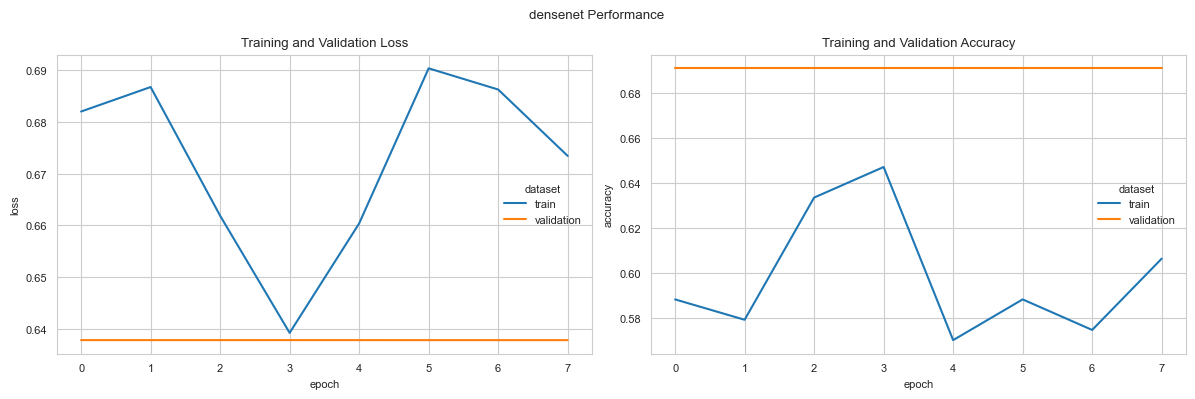

In [11]:

fine_tune_layer = 4
# Order up a checkpoint callback
stage=f"fine_tuning_session_{fine_tune_layer}"
layers = gradual_fine_tuning_schedule[fine_tune_layer]["layers"]
learning_rate = gradual_fine_tuning_schedule[fine_tune_layer]["learning_rate"]

if not force and repo.exists(name=name, stage=stage):
    model, last_epoch = repo.get(name=name, stage=stage)
else:
    repo.remove(name=name, stage=stage) # Remove existing models for the stage
    
    model, history = fine_tune(name=name,
                                    stage=stage,
                                    model=model,
                                    train_ds=train_ds_10,
                                    validation_ds=val_ds_10,
                                    base_model_layer=base_model_layer,
                                    layers=layers,
                                    learning_rate=learning_rate,
                                    last_epoch=last_epoch,
                                    fine_tune_epochs=fine_tune_epochs,
                                    callbacks=early_stop_callback)
    # Check model summary
    model.summary()
    # Visualize learning curve
    x4v(history=history)
    # Extract the last epoch.
    last_epoch = history.epoch[-1]

### Fine Tune Session 5

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                             

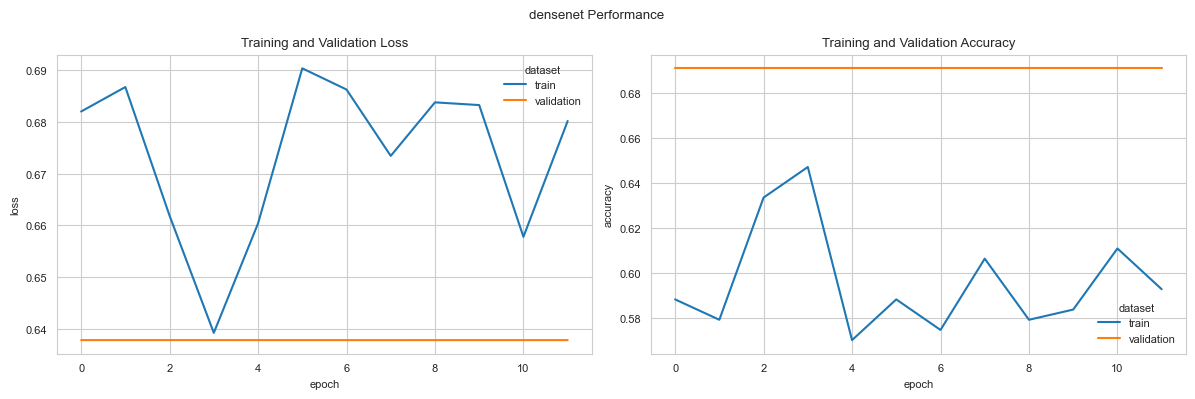

In [12]:

fine_tune_layer = 5
# Order up a checkpoint callback
stage=f"fine_tuning_session_{fine_tune_layer}"
layers = gradual_fine_tuning_schedule[fine_tune_layer]["layers"]
learning_rate = gradual_fine_tuning_schedule[fine_tune_layer]["learning_rate"]

if not force and repo.exists(name=name, stage=stage):
    model, last_epoch = repo.get(name=name, stage=stage)
else:
    repo.remove(name=name, stage=stage) # Remove existing models for the stage
    
    model, history = fine_tune(name=name,
                                    stage=stage,
                                    model=model,
                                    train_ds=train_ds_10,
                                    validation_ds=val_ds_10,
                                    base_model_layer=base_model_layer,
                                    layers=layers,
                                    learning_rate=learning_rate,
                                    last_epoch=last_epoch,
                                    fine_tune_epochs=fine_tune_epochs,
                                    callbacks=early_stop_callback)
    # Check model summary
    model.summary()
    # Visualize learning curve
    x4v(history=history)
    # Extract the last epoch.
    last_epoch = history.epoch[-1]